# Create GIF and Animation for Evapotranspiration Data
ECOSTRESS Tutorials

This code is used for the creation of .gif files and .mp4 files. Use this when dealing with ET data from the ECOSTRESS sensor. If you are using macOS, make sure to use 'brew install ffmpeg' in your terminal.

### Import the Necessary Libraries

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rcParams
import rioxarray as rxr
from mpl_toolkits.axes_grid1 import make_axes_locatable
from datetime import datetime
import numpy as np
from matplotlib.animation import PillowWriter
import pytz
from matplotlib.colors import LinearSegmentedColormap

### Set the Directories

In [2]:
# Replace with the path to the folder where your downloaded imagery is. Make sure to wrap it in quotes
input_directory = r"Replace_With_Your_Input_Folder"

# Replace with the path to the folder where your outputs will go. Make sure to wrap it in quotes
output_directory = r"Replace_With_Your_Output_Folder"

### Set Up Functions to Extract UTC Datetime

In [3]:
# Function to extract title information from filenames
def title_from_file(filename):
    time_info = filename.split('doy')[1][:13]  # Extract date string
    dt = datetime.strptime(time_info, '%Y%j%H%M%S')  # Parse to UTC datetime

    # Convert from UTC to Pacific Time (America/Los_Angeles) ** note that if using a different timezone, you will have to adjust this accordingly **
    utc_dt = pytz.utc.localize(dt)
    pacific_tz = pytz.timezone('America/Los_Angeles') # Adjust timezone if needed
    pacific_dt = utc_dt.astimezone(pacific_tz)

    # Format the date and time to be more readable
    formatted_datetime = pacific_dt.strftime('%Y-%m-%d at %I:%M %p (%Z)')
    title = f"Evapotranspiration (mm/day) {formatted_datetime}"

    return title

# Function to determine if the image is taken during the day or night in Pacific Time
def is_daytime(filename):
    time_info = filename.split('doy')[1][:13]  # Extract date string
    dt = datetime.strptime(time_info, '%Y%j%H%M%S')  # Parse to UTC datetime

    # Convert from UTC to Pacific Time (America/Los_Angeles)
    utc_dt = pytz.utc.localize(dt)
    pacific_tz = pytz.timezone('America/Los_Angeles') # Adjust accordingly
    pacific_dt = utc_dt.astimezone(pacific_tz)

    hour = pacific_dt.hour  # Extract the hour in Pacific Time
    return 6 <= hour <= 18  # Daytime is between 6:00 AM and 6:00 PM Pacific Time

### Identify if Sharpened Image is Daytime or Nighttime

In [4]:
# Get list of all image files in the folder
image_folder = input_directory  # Update this line with the correct folder path that contains the imagery
files_sharpened = sorted([f for f in os.listdir(image_folder) if f.endswith('.tif')])

if not files_sharpened:
    raise FileNotFoundError("No .tif files found in the specified folder.")

# Separate files into daytime and nighttime images
daytime_files = [f for f in files_sharpened if is_daytime(f)]
nighttime_files = [f for f in files_sharpened if not is_daytime(f)]

### Make a Helper Function to Create the GIF

In [9]:
# Helper function to create GIF for a given set of files
def create_gif(file_list, output_file):
    rcParams['animation.html'] = 'jshtml'
    fig = plt.figure()
    ax = fig.add_subplot(111)

    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')

    # Load ET images and apply scale factor if necessary
    ET_rasters = [rxr.open_rasterio(os.path.join(image_folder, file)).squeeze("band", drop=True) * 0.02 for file in file_list]

# Create ET colormap
    ET_COLORMAP = LinearSegmentedColormap.from_list("ET", [
    "#f6e8c3",
    "#d8b365",
    "#99974a",
    "#53792d",
    "#6bdfd2",
    "#1839c5"
])

    # Use a custom colormap
    custom_cmap = ET_COLORMAP.copy()
    custom_cmap.set_under('black')

    # Prepare frames for animation
    frames = []
    for raster_et in ET_rasters:
        np.nan_to_num(raster_et.values, copy=False)  # Replace NaN values with 0
        frames.append(raster_et.values)

    # Initialize the first frame for the animation
    cv0 = frames[0]
    im = ax.imshow(cv0, cmap=custom_cmap)
    cb = fig.colorbar(im, cax=cax, label='Evapotranspiration (mm/day)')
    tx = ax.set_title(title_from_file(file_list[0]))

    # Use tight_layout() to fix the axis label visibility issue
    plt.tight_layout()

    # Animation function
    def animate(i):
        arr = frames[i]
        vmax = np.max(arr[arr > 0.0])
        vmin = np.min(arr[arr > 0.0])
        im.set_data(arr)
        im.set_clim(vmin, vmax)
        tx.set_text(title_from_file(file_list[i]))
        return im, tx

    # Create the animation
    ani = animation.FuncAnimation(fig, animate, frames=len(file_list), interval=1000, blit=True, repeat_delay=5000)

    # Save the animation as a GIF
    print(f"Saving animation to {output_file}")
    ani.save(output_file, writer=PillowWriter(fps=1))
    print(f"Animation successfully saved to {output_file}")

### Save the Outputs

Saving animation to /Users/ggreco/Desktop/PradoDam/AnimationsOutput/ET_animation_daytime.gif
Animation successfully saved to /Users/ggreco/Desktop/PradoDam/AnimationsOutput/ET_animation_daytime.gif
Saving animation to /Users/ggreco/Desktop/PradoDam/AnimationsOutput/ET_animation_nighttime.gif
Animation successfully saved to /Users/ggreco/Desktop/PradoDam/AnimationsOutput/ET_animation_nighttime.gif


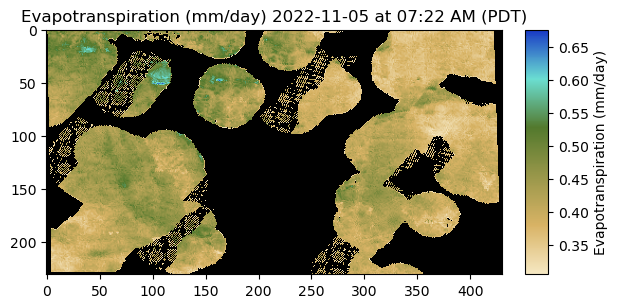

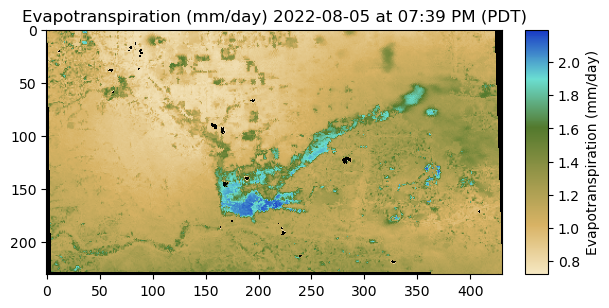

In [11]:
# Create GIF for daytime images
if daytime_files:
    create_gif(daytime_files, f'{output_directory}/ET_animation_daytime.gif')

# Create GIF for nighttime images
if nighttime_files:
    create_gif(nighttime_files, f'{output_directory}/ET_animation_nighttime.gif')

# Creating Animated GIF
This section takes the .gif files created above and converts them to animated .mp4 files.

### Setting up Environment

In [ ]:
### Specifying the FFmpeg path to make it executable in the code
import matplotlib as mpl

# Set the path to the ffmpeg executable
mpl.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'  # Adjust the path if necessary by checking your terminal

### Set Up Functions to Extract UTC Datetime

In [12]:
# Function to extract title information from filenames
def title_from_file(filename):
    time_info = filename.split('doy')[1][:13]  # '2024002071024'
    dt = datetime.strptime(time_info, '%Y%j%H%M%S')  # Parse to UTC datetime

    # Convert from UTC to Pacific Time (America/Los_Angeles) ** note that if using a different timezone, you will have to adjust this accordingly **
    utc_dt = pytz.utc.localize(dt)
    pacific_tz = pytz.timezone('America/Los_Angeles') # Adjust accordingly
    pacific_dt = utc_dt.astimezone(pacific_tz)

    # Format the date and time to be more readable
    formatted_datetime = pacific_dt.strftime('%Y-%m-%d at %I:%M %p (%Z)')
    title = f"Evapotranspiration (mm/day)  {formatted_datetime}"

    return title

# Function to determine if the image is taken during the day or night in Pacific Time
def is_daytime(filename):
    time_info = filename.split('doy')[1][:13]  # Extract date string
    dt = datetime.strptime(time_info, '%Y%j%H%M%S')  # Parse to UTC datetime

    # Convert from UTC to Pacific Time (America/Los_Angeles)
    utc_dt = pytz.utc.localize(dt)
    pacific_tz = pytz.timezone('America/Los_Angeles') # Adjust accordingly
    pacific_dt = utc_dt.astimezone(pacific_tz)

    hour = pacific_dt.hour  # Extract the hour in Pacific Time
    return 6 <= hour <= 18  # Daytime is between 6:00 AM and 6:00 PM Pacific Time


### Identify if Sharpened Image is Daytime or Nighttime

In [13]:
# Get list of all image files in the folder
files_sharpened = sorted([f for f in os.listdir(image_folder) if f.endswith('.tif')])

# Separate files into daytime and nighttime images
daytime_files = [f for f in files_sharpened if is_daytime(f)]
nighttime_files = [f for f in files_sharpened if not is_daytime(f)]

### Helper Function to Create .mp4 File

In [18]:
# Function to create the animation
def create_animation(file_list, output_file):
    rcParams['animation.html'] = 'jshtml'
    fig = plt.figure()
    ax = fig.add_subplot(111)

    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')

    # Load ET images and apply scale factor if needed
    ET_rasters = [
        (rxr.open_rasterio(os.path.join(image_folder, file))
         .squeeze("band", drop=True) * 0.02).values
        for file in file_list
    ]

    # Create ET colormap
    ET_COLORMAP = LinearSegmentedColormap.from_list("ET", [
    "#f6e8c3",
    "#d8b365",
    "#99974a",
    "#53792d",
    "#6bdfd2",
    "#1839c5"
])

    # Use a custom colormap
    custom_cmap = ET_COLORMAP.copy()
    custom_cmap.set_under('black')

    # Prepare frames for animation
    frames = []
    for raster_et in ET_rasters:
        np.nan_to_num(raster_et, copy=False)  # Replace NaN values with 0
        frames.append(raster_et)

    # Initialize the first frame for the animation
    cv0 = frames[0]
    im = ax.imshow(cv0, cmap=custom_cmap)
    cb = fig.colorbar(im, cax=cax, label='Evapotranspiration (mm/day)')
    tx = ax.set_title(title_from_file(file_list[0]))

    # Use tight_layout() to fix the axis label visibility issue
    plt.tight_layout()

    # Animation function
    def animate(i):
        arr = frames[i]
        vmax = np.max(arr[arr > 0.0]) if np.any(arr > 0) else 1
        vmin = np.min(arr[arr > 0.0]) if np.any(arr > 0) else 0
        im.set_data(arr)
        im.set_clim(vmin, vmax)
        tx.set_text(title_from_file(file_list[i]))
        return im, tx

    # Create the animation
    ani = animation.FuncAnimation(fig, animate, frames=len(file_list), interval=1000, blit=True, repeat_delay=5000)

    # Save the animation as an MP4
    print(f"Saving animation to {output_file}")
    ani.save(output_file, writer='ffmpeg', fps=2)
    print(f"Animation successfully saved to {output_file}")

### Save the Outputs

Saving animation to /Users/ggreco/Desktop/PradoDam/AnimationsOutput/ET_animation_daytime.mp4
Animation successfully saved to /Users/ggreco/Desktop/PradoDam/AnimationsOutput/ET_animation_daytime.mp4
Saving animation to /Users/ggreco/Desktop/PradoDam/AnimationsOutput/ET_animation_nighttime.mp4
Animation successfully saved to /Users/ggreco/Desktop/PradoDam/AnimationsOutput/ET_animation_nighttime.mp4


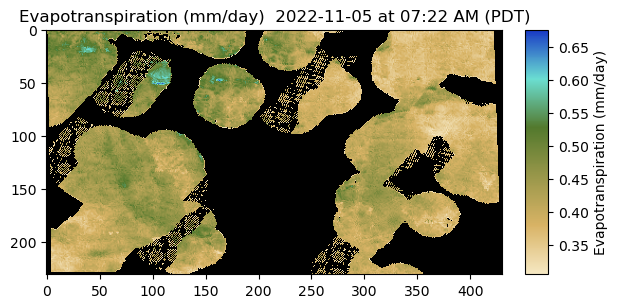

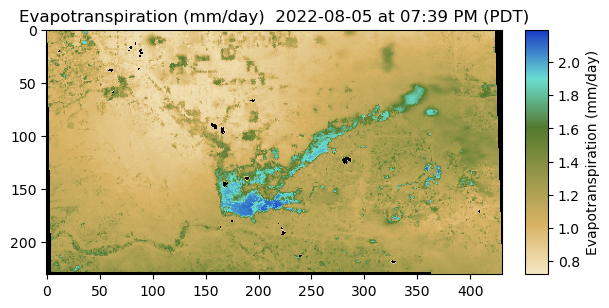

In [25]:
# Create daytime animation
if daytime_files:
    create_animation(daytime_files, f'{output_directory}/ET_animation_daytime.mp4')
# Create nighttime animation
if nighttime_files:
    create_animation(nighttime_files, f'{output_directory}/ET_animation_nighttime.mp4')

# Animations with Standardized Values
If you need to create the animations but with standardized values, the following code cells provide the steps to do so. The process is very similar to what we just ran, however you will be creating and adjusting the min-max values for the ET data that you are working with.

### Set up Functions to Extract UTC Datetime

In [26]:
# Function to extract title information from filenames
def title_from_file(filename):
    time_info = filename.split('doy')[1][:13]  # '2024002071024'
    dt = datetime.strptime(time_info, '%Y%j%H%M%S')  # Parse to UTC datetime

    # Convert from UTC to Pacific Time (America/Los_Angeles) ** note that if using a different timezone, you will have to adjust this accordingly **
    utc_dt = pytz.utc.localize(dt)
    pacific_tz = pytz.timezone('America/Los_Angeles') # Adjust accordingly
    pacific_dt = utc_dt.astimezone(pacific_tz)

    # Format the date and time to be more readable
    formatted_datetime = pacific_dt.strftime('%Y-%m-%d at %I:%M %p (%Z)')
    title = f"Evapotranspiration (mm/day)  {formatted_datetime}"

    return title

# Function to determine if the image is taken during the day or night in Pacific Time
def is_daytime(filename):
    time_info = filename.split('doy')[1][:13]  # Extract date string
    dt = datetime.strptime(time_info, '%Y%j%H%M%S')  # Parse to UTC datetime

    # Convert from UTC to Pacific Time (America/Los_Angeles)
    utc_dt = pytz.utc.localize(dt)
    pacific_tz = pytz.timezone('America/Los_Angeles') # Adjust accordingly
    pacific_dt = utc_dt.astimezone(pacific_tz)

    hour = pacific_dt.hour  # Extract the hour in Pacific Time
    return 6 <= hour <= 18  # Daytime is between 6:00 AM and 6:00 PM Pacific Time

### Identify if Sharpened Image is Daytime or Nighttime

In [27]:
# Get list of all image files in the folder
files_sharpened = sorted([f for f in os.listdir(image_folder) if f.endswith('.tif')])

# Separate files into daytime and nighttime images
daytime_files = [f for f in files_sharpened if is_daytime(f)]
nighttime_files = [f for f in files_sharpened if not is_daytime(f)]

### Helper Function to Create Standardized .mp4 File

In [28]:
# Helper function to create the animation with fixed vmin and vmax
def create_animation(file_list, output_file, vmin, vmax):
    rcParams['animation.html'] = 'jshtml'
    fig = plt.figure()
    ax = fig.add_subplot(111)

    div = make_axes_locatable(ax)
    cax = div.append_axes('right', '5%', '5%')

    # Load ET images and apply scale factor if needed
    ET_rasters = [(rxr.open_rasterio(os.path.join(image_folder, file)).squeeze("band", drop=True) * 0.02).values for file in file_list]

    # Create ET colormap
    ET_COLORMAP = LinearSegmentedColormap.from_list("ET", [
    "#f6e8c3",
    "#d8b365",
    "#99974a",
    "#53792d",
    "#6bdfd2",
    "#1839c5"
])

    # Use a custom colormap
    custom_cmap = ET_COLORMAP.copy()
    custom_cmap.set_under('black')

    # Prepare frames for animation
    frames = []
    for raster_et in ET_rasters:
        np.nan_to_num(raster_et, copy=False)  # Replace NaN values with 0
        frames.append(raster_et)

    # Initialize the first frame for the animation
    cv0 = frames[0]
    im = ax.imshow(cv0, cmap=custom_cmap, vmin=vmin, vmax=vmax)  # Set vmin and vmax for fixed scale
    cb = fig.colorbar(im, cax=cax, label='Evapotranspiration (mm/day)')
    tx = ax.set_title(title_from_file(file_list[0]))

    # Use tight_layout() to fix the axis label visibility issue
    plt.tight_layout()

    # Animation function
    def animate(i):
        arr = frames[i]
        im.set_data(arr)
        tx.set_text(title_from_file(file_list[i]))
        return im, tx

    # Create the animation
    ani = animation.FuncAnimation(fig, animate, frames=len(file_list), interval=1000, blit=True, repeat_delay=5000)

    # Save the animation as an MP4
    print(f"Saving animation to {output_file}")
    ani.save(output_file, writer='ffmpeg', fps=2)
    print(f"Animation successfully saved to {output_file}")

### Save the Standardized Outputs

Saving animation to /Users/ggreco/Desktop/PradoDam/AnimationsOutput/ET_animation_daytime_fixed_scale.mp4
Animation successfully saved to /Users/ggreco/Desktop/PradoDam/AnimationsOutput/ET_animation_daytime_fixed_scale.mp4
Saving animation to /Users/ggreco/Desktop/PradoDam/AnimationsOutput/ET_animation_nighttime_fixed_scale.mp4
Animation successfully saved to /Users/ggreco/Desktop/PradoDam/AnimationsOutput/ET_animation_nighttime_fixed_scale.mp4


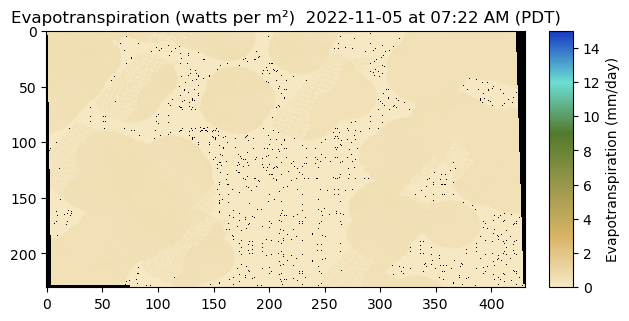

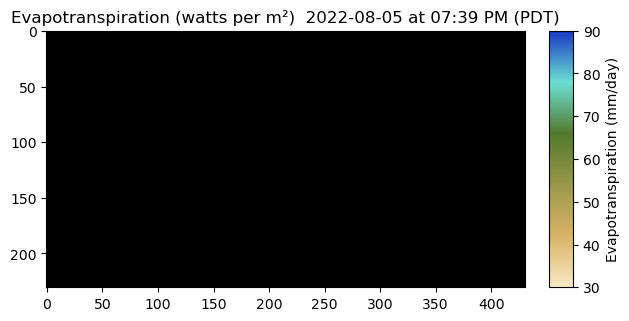

In [29]:
# Create daytime animation with fixed vmin and vmax
if daytime_files:
    create_animation(daytime_files, f'{output_directory}/ET_animation_daytime_fixed_scale.mp4', vmin=0, vmax=15) # EXAMPLE VALUES. Adjust vmin and vmax according to YOUR data


# Create nighttime animation with fixed vmin=30 and vmax=90
if nighttime_files:
    create_animation(nighttime_files, f'{output_directory}/ET_animation_nighttime_fixed_scale.mp4', vmin=30, vmax=90) # EXAMPLE VALUES. Adjust vmin and vmax according to YOUR data